# HuggingFace CSV Dataset Translation Pipeline

Translate columns of a HuggingFace CSV dataset using configurable OVOS translation plugins.

### Supported Translation Backends

| Plugin | Package | Notes |
|---|---|---|
| `google` | `ovos-google-translate-plugin` | Free, rate-limited, no local model |
| `nllb` | `ovos-translate-plugin-nllb` | Local NLLB-200 via CTranslate2, multiple model sizes |
| `gguf` | `ovos-gguf-translate-plugin` | Local LLM (TowerInstruct-7B), limited languages |

### Features
- All parameters configurable via environment variables
- Automatic streaming for datasets > 1 GB
- Chunked translation with checkpointing (resume on failure)
- Per-plugin model/parameter configuration via env vars
- Translation benchmarks, throughput plots, and sample verification

### Example Dataset
[`OpenVoiceOS/ovos-intents-train-latest`](https://huggingface.co/datasets/OpenVoiceOS/ovos-intents-train-latest) — multilingual intent classification (~122 k rows, ~11 MB)

---

> **Credits:** Funded through the [NGI0 Commons Fund](https://nlnet.nl/commonsfund) via [NLnet](https://nlnet.nl), with support from the European Commission's Next Generation Internet programme (grant No 101135429).

---
## 0 · Global Configuration

All parameters are set via `os.environ.setdefault()`.  
Override from your shell, a `.env` file, or `%env` magic **before** running the config cell.

In [24]:
import os

# ──────────────────────────────────────────────────────
# DATASET
# ──────────────────────────────────────────────────────
os.environ.setdefault("HF_DATASET",         "OpenVoiceOS/ovos-intents-train-latest")  # HuggingFace dataset ID
os.environ.setdefault("HF_SPLIT",           "test")              # Dataset split to translate
os.environ.setdefault("HF_SUBSET",          "")                   # Dataset subset/config (empty = default)

# ──────────────────────────────────────────────────────
# COLUMNS
#   TARGET_COLUMNS : comma-separated column names to translate
#   COLUMNS_TO_KEEP: comma-separated column names to keep unchanged
#                    (use "*" to keep all columns)
# ──────────────────────────────────────────────────────
os.environ.setdefault("TARGET_COLUMNS",     "sentence")           # Columns to translate
os.environ.setdefault("COLUMNS_TO_KEEP",    "*")                  # Columns to keep unchanged

# ──────────────────────────────────────────────────────
# LANGUAGE
# ──────────────────────────────────────────────────────
os.environ.setdefault("SOURCE_LANG",        "en")                 # Source language code
os.environ.setdefault("TARGET_LANG",        "es")                 # Target language code
os.environ.setdefault("LANG_COLUMN",        "lang")               # Column with per-row language (empty = use SOURCE_LANG for all)
os.environ.setdefault("SKIP_TARGET_LANG",   "1")                  # Skip rows already in TARGET_LANG (1=yes, 0=no)

# ──────────────────────────────────────────────────────
# TRANSLATION PLUGIN
#   google | nllb | gguf
# ──────────────────────────────────────────────────────
os.environ.setdefault("TX_PLUGIN",          "nllb")               # Translation backend

# ── Google Translate options ──────────────────────────
# (no model config needed — uses free Google Translate API)

# ── NLLB options ──────────────────────────────────────
os.environ.setdefault("NLLB_MODEL",         "nllb-200_600M_int8") # Model name (see table in README)
os.environ.setdefault("NLLB_DEVICE",        "cuda")                # cpu | cuda
os.environ.setdefault("NLLB_BEAM_SIZE",     "4")                  # Beam size for translation

# ── GGUF options ──────────────────────────────────────
os.environ.setdefault("GGUF_MODEL",         "TheBloke/TowerInstruct-7B-v0.1-GGUF")  # HF repo or local path
os.environ.setdefault("GGUF_GPU_LAYERS",    "-1")                  # Layers to offload to GPU (-1 = all)
os.environ.setdefault("GGUF_SYSTEM_PROMPT", """You are a professional translator.
    Your task is to translate OpenVoiceOS .intent files.

    RULES:
     - each sentence may contain variables between curly braces -> {variable}
     - the {variable_name} inside should NEVER be modified, only translate surrounding text
     - optional words may be indicated between square brackets -> [optional text]
     - alternative text can be indicated with parenthesis and | -> (this|that)
     - you can modify/add/remove optional/alternative words depending on if they make sense for the target language
     - you can NOT modify/add/remove variables, only change the position inside the sentence
     - if there are multiple variables in a sentence, there MUST be some text between them
    """)

# ──────────────────────────────────────────────────────
# PROCESSING
# ──────────────────────────────────────────────────────
os.environ.setdefault("BATCH_SIZE",         "64")                 # Rows per checkpoint batch
os.environ.setdefault("STREAM_THRESHOLD_GB","1")                  # Stream dataset if > this size (GB)
os.environ.setdefault("MAX_ROWS",           "0")                  # Limit rows (0 = all)

# ──────────────────────────────────────────────────────
# OUTPUT
# ──────────────────────────────────────────────────────
os.environ.setdefault("OUTPUT_DIR",         "translated_output")  # Output directory
os.environ.setdefault("OUTPUT_FORMAT",      "csv")                # csv | parquet
os.environ.setdefault("HF_UPLOAD",          "0")                  # Upload to HuggingFace Hub (1=yes)
os.environ.setdefault("HF_REPO_ID",         "")                   # Target HF repo for upload
os.environ.setdefault("HF_TOKEN",           "")                   # HF write token


# ──────────────────────────────────────────────────────
# Helpers
# ──────────────────────────────────────────────────────
def _env(key, default=""):
    return os.environ.get(key, default)

def _flag(key):
    return _env(key, "0").strip().lower() in ("1", "true", "yes")

def _int(key, default=0):
    try:
        return int(_env(key, str(default)))
    except ValueError:
        return default

def _float(key, default=0.0):
    try:
        return float(_env(key, str(default)))
    except ValueError:
        return default


# Parse list env vars
TARGET_COLUMNS = [c.strip() for c in _env("TARGET_COLUMNS").split(",") if c.strip()]
COLUMNS_TO_KEEP = _env("COLUMNS_TO_KEEP").strip()
TX_PLUGIN = _env("TX_PLUGIN").strip().lower()

print("Configuration loaded.")
print(f"  Dataset        : {_env('HF_DATASET')} (split={_env('HF_SPLIT')})")
print(f"  Translate cols : {TARGET_COLUMNS}")
print(f"  Keep cols      : {COLUMNS_TO_KEEP}")
print(f"  Direction      : {_env('SOURCE_LANG')} → {_env('TARGET_LANG')}")
print(f"  Lang column    : {_env('LANG_COLUMN') or '(none — all rows treated as SOURCE_LANG)'}")
print(f"  Skip target    : {_flag('SKIP_TARGET_LANG')}")
print(f"  Plugin         : {TX_PLUGIN}")
if TX_PLUGIN == "nllb":
    print(f"    model={_env('NLLB_MODEL')}  device={_env('NLLB_DEVICE')}  beam={_env('NLLB_BEAM_SIZE')}")
elif TX_PLUGIN == "gguf":
    print(f"    model={_env('GGUF_MODEL') or '(default TowerInstruct)'}  gpu_layers={_env('GGUF_GPU_LAYERS')}")
print(f"  Batch size     : {_env('BATCH_SIZE')}")
print(f"  Output         : {_env('OUTPUT_DIR')} ({_env('OUTPUT_FORMAT')})")

Configuration loaded.
  Dataset        : OpenVoiceOS/ovos-intents-train-latest (split=test)
  Translate cols : ['sentence']
  Keep cols      : *
  Direction      : en → es
  Lang column    : lang
  Skip target    : True
  Plugin         : nllb
    model=nllb-200_600M_int8  device=cuda  beam=4
  Batch size     : 64
  Output         : translated_output (csv)


---
## 1 · Install Dependencies

Only the selected plugin is installed to minimize storage.

In [25]:
!pip install --quiet --break-system-packages datasets pandas tqdm matplotlib

import subprocess, sys

if TX_PLUGIN == "google":
    !pip install --quiet --break-system-packages ovos-google-translate-plugin
elif TX_PLUGIN == "nllb":
    !pip install --quiet --break-system-packages ovos-translate-plugin-nllb
elif TX_PLUGIN == "gguf":
    !pip install --quiet --break-system-packages ovos-gguf-plugin
else:
    raise ValueError(f"Unknown TX_PLUGIN: {TX_PLUGIN!r}. Use: google | nllb | gguf")

print(f"\nInstalled plugin: {TX_PLUGIN}")


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

Installed plugin: nllb


---
## 2 · Load Dataset

Streams the dataset if size exceeds `STREAM_THRESHOLD_GB`, otherwise loads into memory.  
The intents dataset is ~11 MB so it loads directly.

In [26]:
import pandas as pd
from datasets import load_dataset, load_dataset_builder
from pathlib import Path

dataset_name = _env("HF_DATASET")
split = _env("HF_SPLIT")
subset = _env("HF_SUBSET") or None
stream_threshold = _float("STREAM_THRESHOLD_GB", 1.0)
max_rows = _int("MAX_ROWS", 0)

# ── Check dataset size to decide streaming ──
use_streaming = False
try:
    builder = load_dataset_builder(dataset_name, subset)
    ds_info = builder.info
    size_bytes = ds_info.download_size or 0
    size_gb = size_bytes / (1024 ** 3)
    print(f"Dataset download size: {size_bytes / (1024**2):.1f} MB")
    if size_gb > stream_threshold:
        use_streaming = True
        print(f"  → Exceeds {stream_threshold} GB threshold, using streaming mode.")
    else:
        print(f"  → Below {stream_threshold} GB threshold, loading into memory.")
except Exception as e:
    print(f"Could not determine dataset size ({e}), loading into memory.")

# ── Load data ──
if use_streaming:
    print("Streaming dataset...")
    ds_stream = load_dataset(dataset_name, subset, split=split, streaming=True)
    rows = []
    for i, row in enumerate(ds_stream):
        if max_rows > 0 and i >= max_rows:
            break
        rows.append(row)
    df = pd.DataFrame(rows)
else:
    print("Loading dataset into memory...")
    ds = load_dataset(dataset_name, subset, split=split)
    df = ds.to_pandas()
    if max_rows > 0:
        df = df.head(max_rows)

print(f"\nLoaded {len(df):,} rows, {len(df.columns)} columns: {list(df.columns)}")

# ── Validate columns ──
for col in TARGET_COLUMNS:
    if col not in df.columns:
        raise ValueError(f"TARGET_COLUMNS contains '{col}' but dataset only has: {list(df.columns)}")

lang_col = _env("LANG_COLUMN")
if lang_col and lang_col not in df.columns:
    print(f"Warning: LANG_COLUMN '{lang_col}' not found in dataset. Using SOURCE_LANG for all rows.")
    lang_col = ""

# ── Resolve columns to keep ──
if COLUMNS_TO_KEEP == "*":
    keep_cols = list(df.columns)
else:
    keep_cols = [c.strip() for c in COLUMNS_TO_KEEP.split(",") if c.strip()]
    # Always include target columns
    for c in TARGET_COLUMNS:
        if c not in keep_cols:
            keep_cols.append(c)

print(f"Columns to keep: {keep_cols}")
print(f"\nSample rows:")
df.head(5)

Dataset download size: 10.4 MB
  → Below 1.0 GB threshold, loading into memory.
Loading dataset into memory...

Loaded 1,370 rows, 3 columns: ['sentence', 'label', 'lang']
Columns to keep: ['sentence', 'label', 'lang']

Sample rows:


,sentence,label,lang
0,quants països hi ha al nord d'espanya,common_query:common_query,ca
1,hvor gammel er medina,common_query:common_query,da
2,was ist der tiefste punkt der erde,common_query:common_query,de
3,explain the exchange rate of rupee for dollar,common_query:common_query,en
4,¿cuán profundo es el lugar más bajo del planeta?,common_query:common_query,es


---
## 3 · Initialize Translation Plugin

Instantiate the chosen OVOS translation plugin with env-var configuration.

In [38]:
import time

target_lang = _env("TARGET_LANG")
source_lang = _env("SOURCE_LANG")

print(f"Initializing {TX_PLUGIN!r} translation plugin...")
t0 = time.time()

if TX_PLUGIN == "google":
    from ovos_google_translate_plugin import GoogleTranslatePlugin
    tx = GoogleTranslatePlugin(config={})
    
elif TX_PLUGIN == "nllb":
    from ovos_translate_plugin_nllb import NLLB200Translator
    tx = NLLB200Translator(config={
        "model": _env("NLLB_MODEL", "nllb-200_600M_int8"),
        "device": _env("NLLB_DEVICE", "cpu"),
        "beam_size": _int("NLLB_BEAM_SIZE", 4),
    })
    
elif TX_PLUGIN == "gguf":
    from ovos_gguf_plugin.translate import GGUFTextTranslator
    cfg = {}
    if _env("GGUF_MODEL"):
        cfg["model"] = _env("GGUF_MODEL")
    if _int("GGUF_GPU_LAYERS", -1) != 0:
        cfg["n_gpu_layers"] = _int("GGUF_GPU_LAYERS")
    if _env("GGUF_SYSTEM_PROMPT"):
        cfg["system_prompt"] = _env("GGUF_SYSTEM_PROMPT")
    tx = GGUFTextTranslator(config=cfg)

init_time = time.time() - t0
print(f"Plugin initialized in {init_time:.1f}s")

# ── Quick sanity check ──
test_text = "hello world"
test_result = tx.translate(test_text, target_lang, source_lang)
print(f"\nSanity check: '{test_text}' → '{test_result}'")

Initializing 'nllb' translation plugin...
Plugin initialized in 0.8s

Sanity check: 'hello world' → 'Hola mundo'


---
## 4 · Translate Dataset

Translates all `TARGET_COLUMNS` row-by-row with:
- Per-row source language detection (via `LANG_COLUMN` if available)
- Optional skipping of rows already in the target language
- Checkpointing every `BATCH_SIZE` rows for crash recovery
- Timing for benchmarks

In [39]:
from tqdm import tqdm
import json
import traceback

batch_size = _int("BATCH_SIZE", 64)
skip_target = _flag("SKIP_TARGET_LANG")
output_dir = Path(_env("OUTPUT_DIR", "translated_output"))
output_dir.mkdir(parents=True, exist_ok=True)
checkpoint_path = output_dir / "_checkpoint.json"

# ── Resume from checkpoint if exists ──
start_idx = 0
if checkpoint_path.exists():
    try:
        ckpt = json.loads(checkpoint_path.read_text())
        start_idx = ckpt.get("next_idx", 0)
        print(f"Resuming from checkpoint at row {start_idx:,}")
    except Exception:
        start_idx = 0

# ── Prepare translated columns ──
for col in TARGET_COLUMNS:
    tx_col = f"{col}_{target_lang}"
    if tx_col not in df.columns:
        df[tx_col] = ""

# ── Translation loop with benchmarks ──
timings = []  # (row_idx, chars, seconds)
errors = []   # (row_idx, col, error_msg)
skipped = 0
translated = 0

total = len(df)
pbar = tqdm(range(start_idx, total), desc="Translating", initial=start_idx, total=total)

for i in pbar:
    row = df.iloc[i]
    
    # Determine source language for this row
    if lang_col and lang_col in df.columns:
        row_lang = str(row[lang_col]).strip().lower()
    else:
        row_lang = source_lang
    
    # Skip rows not in source language
    if skip_target and row_lang == target_lang:
        for col in TARGET_COLUMNS:
            df.at[i, f"{col}_{target_lang}"] = str(row[col])
        skipped += 1
        continue
    
    # Translate each target column
    for col in TARGET_COLUMNS:
        text = str(row[col]).strip()
        if not text:
            df.at[i, f"{col}_{target_lang}"] = ""
            continue
        
        t0 = time.time()
        try:
            result = tx.translate(text, target_lang, row_lang)
            #print(result)
            elapsed = time.time() - t0
            df.at[i, f"{col}_{target_lang}"] = result
            timings.append((i, len(text), elapsed))
            translated += 1
        except Exception as e:
            elapsed = time.time() - t0
            df.at[i, f"{col}_{target_lang}"] = f"[ERROR: {e}]"
            errors.append((i, col, str(e)))
            timings.append((i, len(text), elapsed))
    
    # Checkpoint
    if (i + 1) % batch_size == 0:
        checkpoint_path.write_text(json.dumps({"next_idx": i + 1}))
        pbar.set_postfix(translated=translated, skipped=skipped, errors=len(errors))

# Final checkpoint
checkpoint_path.write_text(json.dumps({"next_idx": total, "complete": True}))

print(f"\n{'='*60}")
print(f"Translation complete!")
print(f"  Translated : {translated:,} cells")
print(f"  Skipped    : {skipped:,} rows (already in {target_lang})")
print(f"  Errors     : {len(errors):,}")
if errors:
    print(f"  First 5 errors:")
    for idx, col, msg in errors[:5]:
        print(f"    row {idx}, col '{col}': {msg[:100]}")

Translating: 100%|██████████| 1370/1370 [01:43<00:00, 13.19it/s, errors=0, skipped=126, translated=1218]


Translation complete!
  Translated : 1,241 cells
  Skipped    : 129 rows (not in en)
  Errors     : 0


---
## 5 · Benchmarks & Throughput Plots

Benchmark Summary (nllb)
  Total translations : 1,241
  Total characters   : 36,323
  Total time         : 102.5s
  Throughput         : 354 chars/s | 12.1 rows/s
  Avg per row        : 82.6 ms (median 78.2 ms)
  p95 latency        : 130.0 ms


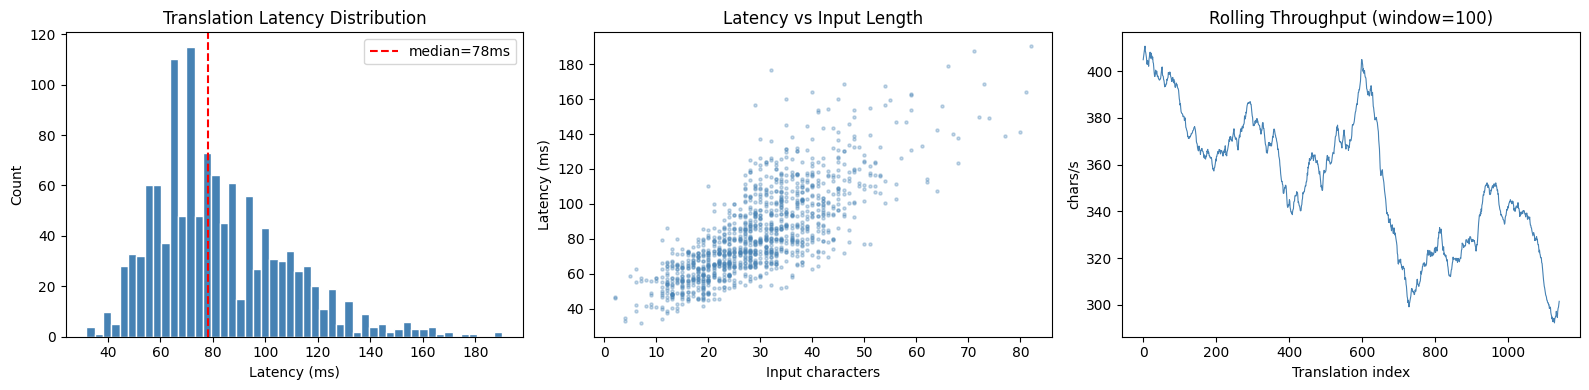


Plots saved to translated_output/benchmark_plots.png


In [40]:
import matplotlib.pyplot as plt
import numpy as np

if not timings:
    print("No translations performed — nothing to benchmark.")
else:
    t_arr = np.array(timings)  # (row_idx, chars, seconds)
    chars = t_arr[:, 1]
    secs = t_arr[:, 2]
    
    total_chars = chars.sum()
    total_time = secs.sum()
    chars_per_sec = total_chars / total_time if total_time > 0 else 0
    rows_per_sec = len(timings) / total_time if total_time > 0 else 0
    
    print(f"Benchmark Summary ({TX_PLUGIN})")
    print(f"  Total translations : {len(timings):,}")
    print(f"  Total characters   : {total_chars:,.0f}")
    print(f"  Total time         : {total_time:,.1f}s")
    print(f"  Throughput         : {chars_per_sec:,.0f} chars/s | {rows_per_sec:,.1f} rows/s")
    print(f"  Avg per row        : {secs.mean()*1000:.1f} ms (median {np.median(secs)*1000:.1f} ms)")
    print(f"  p95 latency        : {np.percentile(secs, 95)*1000:.1f} ms")
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    
    # 1. Latency distribution
    axes[0].hist(secs * 1000, bins=50, color="steelblue", edgecolor="white")
    axes[0].set_xlabel("Latency (ms)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("Translation Latency Distribution")
    axes[0].axvline(np.median(secs) * 1000, color="red", linestyle="--", label=f"median={np.median(secs)*1000:.0f}ms")
    axes[0].legend()
    
    # 2. Chars vs Latency
    axes[1].scatter(chars, secs * 1000, alpha=0.3, s=5, color="steelblue")
    axes[1].set_xlabel("Input characters")
    axes[1].set_ylabel("Latency (ms)")
    axes[1].set_title("Latency vs Input Length")
    
    # 3. Rolling throughput (chars/s over batches)
    window = min(100, len(secs) // 2) or 1
    if len(secs) > window:
        rolling_cps = np.convolve(
            chars / np.where(secs > 0, secs, 1e-6),
            np.ones(window) / window,
            mode="valid"
        )
        axes[2].plot(rolling_cps, color="steelblue", linewidth=0.8)
        axes[2].set_xlabel("Translation index")
        axes[2].set_ylabel("chars/s")
        axes[2].set_title(f"Rolling Throughput (window={window})")
    else:
        axes[2].text(0.5, 0.5, "Not enough data", ha="center", va="center",
                     transform=axes[2].transAxes)
    
    plt.tight_layout()
    plt.savefig(output_dir / "benchmark_plots.png", dpi=150, bbox_inches="tight")
    plt.show()
    print(f"\nPlots saved to {output_dir / 'benchmark_plots.png'}")

---
## 6 · Verification — Sample Translations

Show random samples for manual quality inspection.

In [41]:
n_samples = min(20, len(df))
sample_df = df.sample(n=n_samples, random_state=42)

for col in TARGET_COLUMNS:
    tx_col = f"{col}_{target_lang}"
    print(f"\n{'='*70}")
    print(f"Column: {col} → {tx_col}")
    print(f"{'='*70}")
    for _, row in sample_df.iterrows():
        src_lang_display = row.get(lang_col, source_lang) if lang_col else source_lang
        print(f"  [{src_lang_display}] {str(row[col])[:80]}")
        print(f"  [{target_lang}] {str(row[tx_col])[:80]}")
        print()


Column: sentence → sentence_es
  [gl] dime que acontecementos históricos aconteceron hoxe
  [es] Dígame qué acontecimientos históricos sucedieron hoy.

  [fr] quelle est la météo prévue pour les trois prochains jours?
  [es] ¿Cuál es el tiempo previsto para los próximos tres días?

  [eu] aurkitu {genre} tb saioak
  [es] Encontrar las sesiones de TB

  [eu] kontatu {query} buruzko txiste bat
  [es] Cuéntame un chiste sobre eso.

  [en] remove butter and cheese from shopping
  [es] eliminar la mantequilla y el queso de las compras

  [ca] allarga el temporitzador del pa 2 minuts més
  [es] alarga el temporizador del pan 2 minutos más

  [de] aktiviere audioaufnahme
  [es] activar la grabación de audio

  [en] give info about the movie {movie}
  [es] Dar información sobre la película

  [ca] fes una llista de la compra
  [es] hacer una lista de la compra

  [pt] hoje está ensolarado certo?
  [es] Hoy está soleado, ¿verdad?

  [en] put a nature sound alarm at 7 o’clock
  [es] poner una a

---
## 7 · Verification — Translation Coverage & Error Analysis

Column: sentence → sentence_es
  Total rows     : 1,370
  Empty results  : 0 (0.0%)
  Error results  : 0 (0.0%)
  Identical      : 135 (9.9%)
  Translated     : 1,370

Length ratio (sentence): mean=1.05, median=1.00, std=0.25


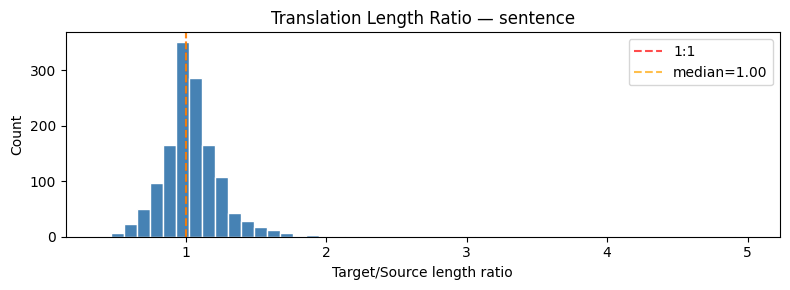

In [42]:
for col in TARGET_COLUMNS:
    tx_col = f"{col}_{target_lang}"
    total_rows = len(df)
    empty_rows = (df[tx_col].astype(str).str.strip() == "").sum()
    error_rows = df[tx_col].astype(str).str.startswith("[ERROR:").sum()
    identical_rows = (df[col].astype(str) == df[tx_col].astype(str)).sum()
    
    print(f"Column: {col} → {tx_col}")
    print(f"  Total rows     : {total_rows:,}")
    print(f"  Empty results  : {empty_rows:,} ({100*empty_rows/total_rows:.1f}%)")
    print(f"  Error results  : {error_rows:,} ({100*error_rows/total_rows:.1f}%)")
    print(f"  Identical      : {identical_rows:,} ({100*identical_rows/total_rows:.1f}%)")
    print(f"  Translated     : {total_rows - empty_rows - error_rows:,}")
    print()

# Length ratio analysis (good translations tend to have similar lengths)
if timings:
    for col in TARGET_COLUMNS:
        tx_col = f"{col}_{target_lang}"
        src_lens = df[col].astype(str).str.len()
        tgt_lens = df[tx_col].astype(str).str.len()
        # Avoid division by zero
        mask = (src_lens > 0) & (~df[tx_col].astype(str).str.startswith("[ERROR:"))
        if mask.sum() > 0:
            ratios = tgt_lens[mask] / src_lens[mask]
            print(f"Length ratio ({col}): mean={ratios.mean():.2f}, median={ratios.median():.2f}, std={ratios.std():.2f}")
            
            fig, ax = plt.subplots(figsize=(8, 3))
            ax.hist(ratios.clip(0, 5), bins=50, color="steelblue", edgecolor="white")
            ax.set_xlabel("Target/Source length ratio")
            ax.set_ylabel("Count")
            ax.set_title(f"Translation Length Ratio — {col}")
            ax.axvline(1.0, color="red", linestyle="--", alpha=0.7, label="1:1")
            ax.axvline(ratios.median(), color="orange", linestyle="--", alpha=0.7, label=f"median={ratios.median():.2f}")
            ax.legend()
            plt.tight_layout()
            plt.savefig(output_dir / f"length_ratio_{col}.png", dpi=150, bbox_inches="tight")
            plt.show()

---
## 8 · Save Translated Dataset

In [43]:
# ── Select output columns ──
out_cols = list(keep_cols)
for col in TARGET_COLUMNS:
    tx_col = f"{col}_{target_lang}"
    if tx_col not in out_cols:
        out_cols.append(tx_col)

# Only include columns that exist
out_cols = [c for c in out_cols if c in df.columns]
df_out = df[out_cols].copy()

output_format = _env("OUTPUT_FORMAT", "csv")
output_file = output_dir / f"translated_{_env('HF_SPLIT')}_{target_lang}.{output_format}"

if output_format == "parquet":
    df_out.to_parquet(output_file, index=False)
else:
    df_out.to_csv(output_file, index=False)

file_size_mb = output_file.stat().st_size / (1024 ** 2)
print(f"Saved {len(df_out):,} rows × {len(out_cols)} columns to {output_file}")
print(f"File size: {file_size_mb:.1f} MB")

# ── Save benchmark summary ──
summary = {
    "dataset": _env("HF_DATASET"),
    "split": _env("HF_SPLIT"),
    "plugin": TX_PLUGIN,
    "source_lang": source_lang,
    "target_lang": target_lang,
    "total_rows": len(df),
    "translated_cells": translated,
    "skipped_rows": skipped,
    "errors": len(errors),
    "plugin_init_time_s": round(init_time, 2),
    "total_translation_time_s": round(sum(t[2] for t in timings), 2) if timings else 0,
    "avg_latency_ms": round(float(np.mean([t[2] for t in timings])) * 1000, 1) if timings else 0,
    "throughput_chars_per_s": round(chars_per_sec, 0) if timings else 0,
}
summary_path = output_dir / "benchmark_summary.json"
summary_path.write_text(json.dumps(summary, indent=2))
print(f"Benchmark summary saved to {summary_path}")

Saved 1,370 rows × 4 columns to translated_output/translated_test_es.csv
File size: 0.2 MB
Benchmark summary saved to translated_output/benchmark_summary.json


---
## 10 · (Optional) Upload to HuggingFace Hub

In [33]:
if _flag("HF_UPLOAD") and _env("HF_REPO_ID"):
    from huggingface_hub import HfApi
    
    api = HfApi(token=_env("HF_TOKEN") or None)
    repo_id = _env("HF_REPO_ID")
    
    print(f"Uploading to {repo_id}...")
    api.create_repo(repo_id, repo_type="dataset", exist_ok=True)
    
    api.upload_file(
        path_or_fileobj=str(output_file),
        path_in_repo=output_file.name,
        repo_id=repo_id,
        repo_type="dataset",
    )
    
    # Upload benchmark summary
    api.upload_file(
        path_or_fileobj=str(summary_path),
        path_in_repo="benchmark_summary.json",
        repo_id=repo_id,
        repo_type="dataset",
    )
    
    print(f"Uploaded to https://huggingface.co/datasets/{repo_id}")
else:
    print("HF upload skipped (set HF_UPLOAD=1 and HF_REPO_ID to enable).")

HF upload skipped (set HF_UPLOAD=1 and HF_REPO_ID to enable).


---
## 11 · Cleanup

Remove checkpoint file and free memory.

In [44]:
import gc

# Remove checkpoint (translation is complete)
if checkpoint_path.exists():
    checkpoint_path.unlink()
    print("Checkpoint removed.")

# Free plugin memory
del tx
gc.collect()

print(f"\nDone! Output files in: {output_dir}")
for f in sorted(output_dir.iterdir()):
    if not f.name.startswith("_"):
        print(f"  {f.name} ({f.stat().st_size / 1024:.0f} KB)")

Checkpoint removed.

Done! Output files in: translated_output
  benchmark_plots.png (156 KB)
  benchmark_summary.json (0 KB)
  length_ratio_sentence.png (27 KB)
  translated_test_es.csv (157 KB)


---
## Appendix — Quick Reference

### Environment Variables

| Variable | Default | Description |
|---|---|---|
| `HF_DATASET` | `OpenVoiceOS/ovos-intents-train-latest` | HuggingFace dataset ID |
| `HF_SPLIT` | `train` | Dataset split |
| `HF_SUBSET` | (empty) | Dataset subset/config |
| `TARGET_COLUMNS` | `sentence` | Comma-separated columns to translate |
| `COLUMNS_TO_KEEP` | `*` | Columns to keep (`*` = all) |
| `SOURCE_LANG` | `en` | Source language code |
| `TARGET_LANG` | `pt` | Target language code |
| `LANG_COLUMN` | `lang` | Column with per-row language |
| `SKIP_TARGET_LANG` | `1` | Skip rows already in target language |
| `TX_PLUGIN` | `nllb` | Translation backend: `google`, `nllb`, `gguf` |
| `NLLB_MODEL` | `nllb-200_600M_int8` | NLLB model name |
| `NLLB_DEVICE` | `cpu` | `cpu` or `cuda` |
| `NLLB_BEAM_SIZE` | `4` | Beam size for NLLB |
| `GGUF_MODEL` | (empty) | GGUF model HF repo or local path |
| `GGUF_GPU_LAYERS` | `0` | GPU layers for GGUF (`-1` = all) |
| `BATCH_SIZE` | `64` | Checkpoint batch size |
| `STREAM_THRESHOLD_GB` | `1` | Stream if dataset > this size |
| `MAX_ROWS` | `0` | Row limit (`0` = all) |
| `OUTPUT_DIR` | `translated_output` | Output directory |
| `OUTPUT_FORMAT` | `csv` | `csv` or `parquet` |
| `HF_UPLOAD` | `0` | Upload to HuggingFace Hub |
| `HF_REPO_ID` | (empty) | Target HF repo |
| `HF_TOKEN` | (empty) | HF write token |
| `RUN_ONNX_BENCHMARK` | `0` | Run ONNX NLLB benchmark |
| `ONNX_NLLB_MODEL` | `facebook/nllb-200-distilled-600M` | Model for ONNX export |
| `ONNX_QUANTIZE` | `1` | Quantize exported ONNX model |

### NLLB Model Options

| Model | Size | Quantization |
|---|---|---|
| `nllb-200_600M_int8` | ~300 MB | int8 |
| `nllb-200_1.2B_int8` | ~600 MB | int8 |
| `nllb-200_3.3B_int8` | ~1.7 GB | int8 |
| `nllb-200-distilled-1.3B-ct2-int8` | ~650 MB | int8, distilled |

### GGUF Supported Languages
English, Portuguese, Spanish, French, German, Dutch, Italian, Korean, Chinese, Russian